#### In this notebook, I built a model that predicts if a certain customer will churn/leave or discontinue their usage of the Expresso network, the data here was downloaded from zindi, it contains roughly four thousand datapoints on the training set.
#### This is an exercise in the 2020 DSN AI+ online prebootcamp 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from IPython.display import display
import warnings
import itertools

warnings.filterwarnings('ignore')
style.use('ggplot')

%matplotlib inline

In [40]:
#Reading in the data

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_subm = pd.read_csv('sample_submission.csv')
data_dscr = pd.read_csv('VariableDefinitions.csv')
train.head(5)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [41]:
data_dscr

,Variable Definitions,Unnamed: 1,Unnamed: 2
0,NaN,French,English
1,NaN,Le dataset churn comprend 19 variables dont 15...,The churn dataset includes 19 variables includ...
2,user_id,NaN,NaN
3,REGION,la localité de chaque client,the location of each client
4,TENURE,la durée dans le reseau,duration in the network
5,MONTANT,montant de recharge,top-up amount
6,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
7,REVENUE,revenu mensuel de chaque client,monthly income of each client
8,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
9,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income


### Cleaning the data

In [43]:
# writing different functions to ensure modularity
#

def check_null(data):
    """
    *** This function returns a fraction of the
        null values per feature in the data
    ** Args:
        Data - pandas dataframe
    ** Return:
        decimal value - (sum of null values per feature / sum of data points)
    """
    print(f"Shape: {data.shape}")
    return data.isnull().sum()/data.shape[0]

def plot_feature_importances(model, data):
    """
    *** Returns a plot of the feature importance as scored by the model
    ** Args:
        Data - pandas dataframe
        Model - Algorithm
    ** Return:
        bar plot
    """
    plt.figure(figsize=(15, 8));
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
def categorical_plot(data):
    """
    *** Return a plot of categorical features in a data
    ** Args:
        Data - pandas dataframe
    ** Return:
        bar plot
    """
    for col in cat_cols:
        if col in data.columns:
            sns.countplot(y=col, hue='CHURN', data=data)
            plt.show()

In [44]:
## Adding train and test data together to prevent repeating the preprocessing stages
##
train['is_train'] = 1
test['is_train'] = 0
all_data = pd.concat([train, test])

In [45]:
check_null(all_data), test.shape, train.shape

Shape: (500000, 20)


(user_id           0.000000
 REGION            0.393626
 TENURE            0.000000
 MONTANT           0.350456
 FREQUENCE_RECH    0.350456
 REVENUE           0.336306
 ARPU_SEGMENT      0.336306
 FREQUENCE         0.336306
 DATA_VOLUME       0.492384
 ON_NET            0.364404
 ORANGE            0.415034
 TIGO              0.598348
 ZONE1             0.921260
 ZONE2             0.936130
 MRG               0.000000
 REGULARITY        0.000000
 TOP_PACK          0.418064
 FREQ_TOP_PACK     0.418064
 CHURN             0.200000
 is_train          0.000000
 dtype: float64,
 (100000, 19),
 (400000, 20))

In [46]:
# getting the list of categorical columns
##

cat_cols = [cname for cname in all_data.drop(['is_train', 'user_id', 'CHURN'], axis=1)
            if all_data[cname].dtype == 'object']

In [47]:
cat_cols

['REGION', 'TENURE', 'MRG', 'TOP_PACK']

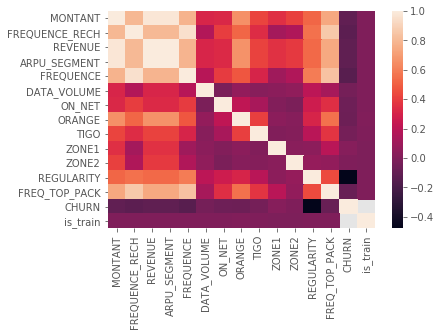

In [48]:
# Visualizing the correlation between the data and the target
##

sns.heatmap(all_data.corr())

In [10]:
### Feature Engineerning
all_data['regularity_churn'] = np.NaN
for i in range(all_data.shape[0]):
    if all_data['REGULARITY'].iloc[i] < 15:
        all_data['regularity_churn'].iloc[i] = 'Likely churned'
    elif all_data['REGULARITY'].iloc[i] > 15 and all_data['REGULARITY'].iloc[i] < 40:
        all_data['regularity_churn'].iloc[i] = 'prone to churn'
    elif all_data['REGULARITY'].iloc[i] > 40:
        all_data['regularity_churn'].iloc[i] = 'Unlikely churned'
cat_cols.append('regularity_churn')

In [11]:
all_data['R_RC'] = all_data['REGULARITY'].map(str) + all_data['regularity_churn'].map(str)

In [12]:
all_data['F_FR'] = all_data['FREQUENCE'].map(str) + all_data['FREQUENCE_RECH'].map(str)
all_data['AS_RE'] = all_data['ARPU_SEGMENT'].map(str) + all_data['REVENUE'].map(str)

In [13]:
all_data['ArE_INCOME'] = all_data['ARPU_SEGMENT'] / all_data['REVENUE']

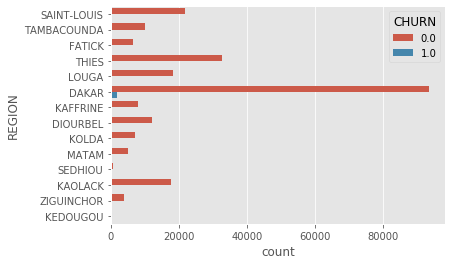

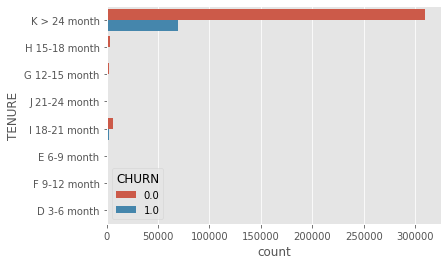

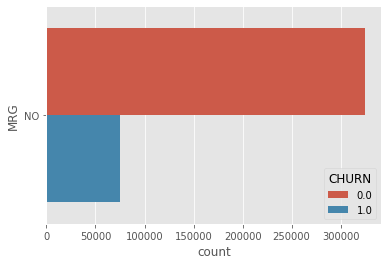

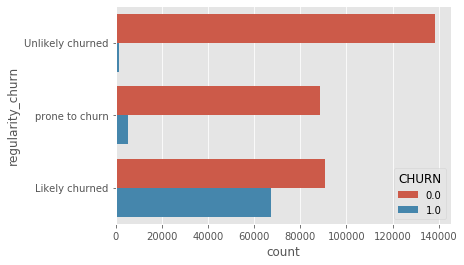

In [14]:
# Visualizing the categorical features before encoding
categorical_plot(all_data.drop(['TOP_PACK'], axis=1))

In [38]:
## One Hot and Label Encoding
all_data = pd.concat( [all_data, pd.get_dummies(all_data['REGION'], prefix='_REG', drop_first=True)], axis=1 )
all_data = pd.concat( [all_data, pd.get_dummies(all_data['TENURE'], prefix='_TEN', drop_first=True)], axis=1 )


all_data['REGION'] = all_data['REGION'].factorize()[0]
all_data['TENURE'] = all_data['TENURE'].factorize()[0]

all_data['TOP_PACK'] = all_data['TOP_PACK'].map(all_data['TOP_PACK'].value_counts())
all_data['regularity_churn'] = all_data['regularity_churn'].map(all_data['regularity_churn'].value_counts())

In [16]:
all_data['R_RC'] = all_data['R_RC'].map(all_data['R_RC'].value_counts())
all_data['F_FR'] = all_data['F_FR'].map(all_data['F_FR'].value_counts())
all_data['AS_RE'] = all_data['AS_RE'].map(all_data['AS_RE'].value_counts())

In [17]:
all_data.drop(['ZONE1', 'ZONE2', 'MRG'], axis=1, inplace=True)

In [18]:
all_data['ArE_INCOME'] = all_data['ArE_INCOME'].fillna(-999)

In [19]:
nan_cols = [cname for cname in all_data.columns
            if all_data[cname].isnull().sum() > 0]
nan_cols.remove('CHURN')

In [20]:
all_data['regularity_churn'] = all_data['regularity_churn'].fillna(all_data['regularity_churn'].mean())
nan_cols.remove('regularity_churn')

In [21]:
for i in range(len(nan_cols)):
    all_data[nan_cols[i]] = all_data[nan_cols[i]].fillna(all_data[nan_cols[i]].median())
    
check_null(all_data)

Shape: (500000, 42)


user_id               0.0
REGION                0.0
TENURE                0.0
MONTANT               0.0
FREQUENCE_RECH        0.0
REVENUE               0.0
ARPU_SEGMENT          0.0
FREQUENCE             0.0
DATA_VOLUME           0.0
ON_NET                0.0
ORANGE                0.0
TIGO                  0.0
REGULARITY            0.0
TOP_PACK              0.0
FREQ_TOP_PACK         0.0
CHURN                 0.2
is_train              0.0
regularity_churn      0.0
R_RC                  0.0
F_FR                  0.0
AS_RE                 0.0
ArE_INCOME            0.0
_REG_DIOURBEL         0.0
_REG_FATICK           0.0
_REG_KAFFRINE         0.0
_REG_KAOLACK          0.0
_REG_KEDOUGOU         0.0
_REG_KOLDA            0.0
_REG_LOUGA            0.0
_REG_MATAM            0.0
_REG_SAINT-LOUIS      0.0
_REG_SEDHIOU          0.0
_REG_TAMBACOUNDA      0.0
_REG_THIES            0.0
_REG_ZIGUINCHOR       0.0
_TEN_E 6-9 month      0.0
_TEN_F 9-12 month     0.0
_TEN_G 12-15 month    0.0
_TEN_H 15-18

In [22]:
all_data.describe()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,_REG_TAMBACOUNDA,_REG_THIES,_REG_ZIGUINCHOR,_TEN_E 6-9 month,_TEN_F 9-12 month,_TEN_G 12-15 month,_TEN_H 15-18 month,_TEN_I 18-21 month,_TEN_J 21-24 month,_TEN_K > 24 month
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,2.536640,0.160624,4641.726616,9.930748,4664.587018,1554.865890,12.290246,1840.762494,185.650376,67.845162,...,0.025738,0.083350,0.010036,0.000888,0.004430,0.006976,0.012138,0.020850,0.005804,0.948528
std,3.624154,0.775031,5851.437382,10.913042,5965.135263,1988.375196,12.182699,8654.035204,706.306282,159.553315,...,0.158353,0.276411,0.099676,0.029786,0.066411,0.083231,0.109502,0.142882,0.075963,0.220959
min,-1.000000,0.000000,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,0.000000,2000.000000,4.000000,1900.000000,633.000000,6.000000,241.000000,12.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,0.000000,3000.000000,7.000000,3000.000000,1000.000000,9.000000,267.000000,27.000000,29.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,0.000000,4600.000000,10.000000,4700.000000,1567.000000,13.000000,300.000000,55.000000,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,13.000000,7.000000,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
## Normalizing the data
from scipy.stats import skew, norm

#Getting the numerical columns
num_cols = [cname for cname in all_data.drop(['is_train', 'user_id', 'CHURN'], axis=1)
            if cname not in cat_cols]

skew_feats = all_data[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_feats = skew_feats[skew_feats > 0.5]
skew_index = high_skew_feats

skewed_feats = pd.DataFrame({'Skewed' : high_skew_feats})
skewed_feats.head(5)

,Skewed
_REG_KEDOUGOU,47.319688
DATA_VOLUME,35.821392
_TEN_E 6-9 month,33.513087
_REG_SEDHIOU,26.387537
TIGO,18.477329


In [24]:
high_skew_feats.index
selected_skew_feats = ['R_RC', 'AS_RE', 'FREQUENCE_RECH', 'ON_NET', 'TIGO',
                        'FREQUENCE', 'R_RC', 'MONTANT', 'ORANGE', 'DATA_VOLUME', 
                        'ARPU_SEGMENT', 'REVENUE', 'FREQ_TOP_PACK',]

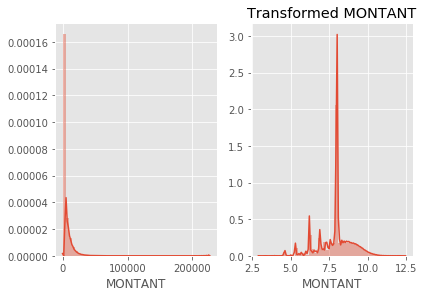

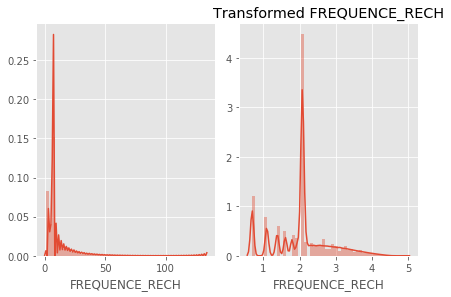

In [25]:
# Visualizing the a few of the skewed features
for cname in ['MONTANT', 'FREQUENCE_RECH']:
    fig, ax = plt.subplots(1, 2)
    
    sns.distplot(all_data[cname], ax=ax[0])    #Plots the original datapoints
    sns.distplot(np.log1p(all_data[cname]), ax=ax[1])    #Plots the transformed datapoints
    
    plt.title(f"Transformed {cname}")

In [26]:
for cname in selected_skew_feats:
    all_data[cname] = np.log1p(all_data[cname])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
train_data = all_data.loc[all_data['is_train']==1]
test_data = all_data.loc[all_data['is_train']==0]

train_data.shape, test_data.shape

((400000, 42), (100000, 42))

In [29]:
target = train_data['CHURN']
train_data.drop(['user_id', 'CHURN', 'is_train'], axis=1, inplace=True)
test_index = test_data.index
test_data.drop(['user_id', 'CHURN', 'is_train'], axis=1, inplace=True)

In [30]:
feature_train, feature_test, label_train, label_test = train_test_split(train_data, target,
                                                                           stratify=target, test_size=0.25,
                                                                           random_state=0)

In [31]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()
decision_tree = DecisionTreeClassifier()

In [32]:
lr.fit(feature_train, label_train)
rf.fit(feature_train, label_train)
gbm.fit(feature_train, label_train)
decision_tree.fit(feature_train, label_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
print('Logistic Regression Log loss: {}'.format(log_loss(label_test, lr.predict_proba(feature_test)[:,1])))
print('RandomForestClassifier Log loss: {}'.format(log_loss(label_test, rf.predict_proba(feature_test)[:,1])))
print('GradientBoostingClassifier Log loss: {}'.format(log_loss(label_test, gbm.predict_proba(feature_test)[:,1])))
print('DecisionTreeClassifier Log loss: {}'.format(log_loss(label_test, decision_tree.predict_proba(feature_test)[:,1])))

Logistic Regression Log loss: 0.308576027024899
RandomForestClassifier Log loss: 0.32467004761602314
GradientBoostingClassifier Log loss: 0.25419649593289767
DecisionTreeClassifier Log loss: 2.2730474241168332


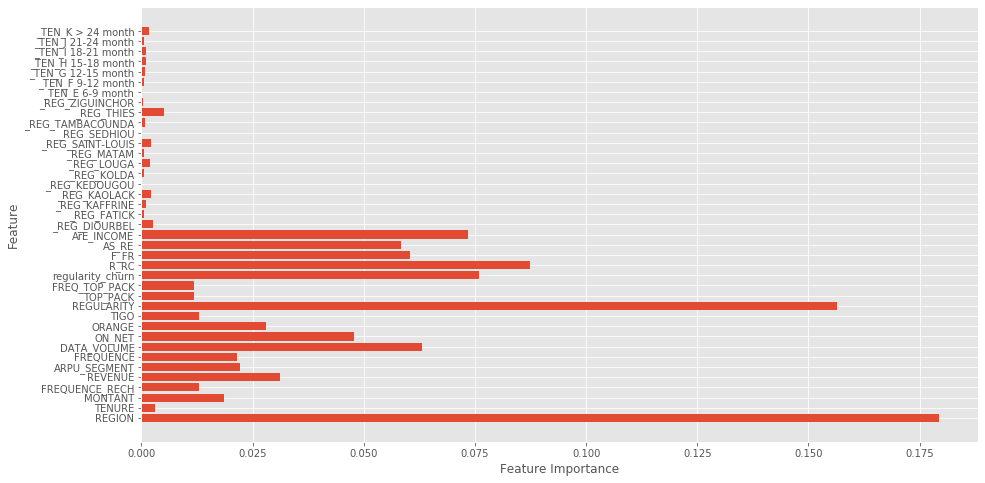

In [34]:
# Plotting the feature Importance

plot_feature_importances(rf, train_data)

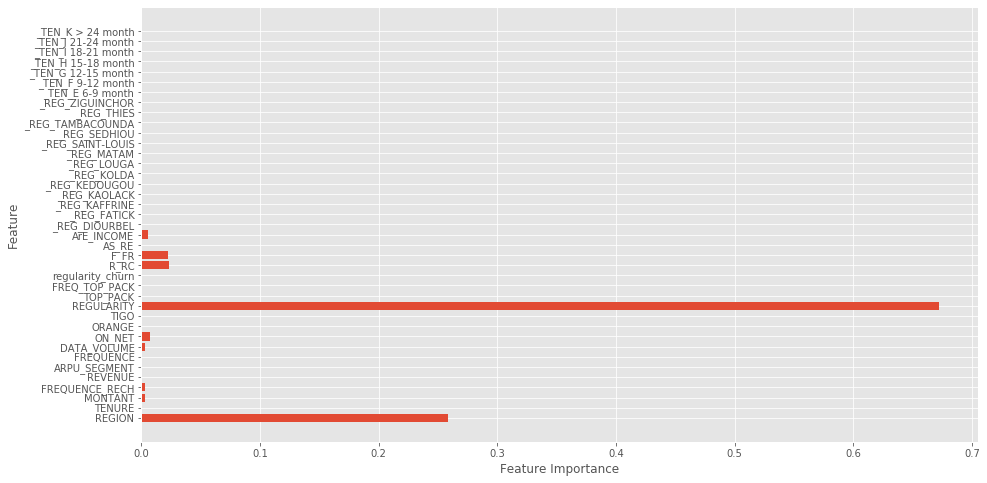

In [35]:
plot_feature_importances(gbm, train_data)

In [37]:
gbm.fit(train_data, target)
prediction = gbm.predict_proba(test_data)

my_submission = pd.DataFrame({'user_id':test['user_id'],
                              'CHURN':prediction[:,1]}, index=None)
my_submission.to_csv('my_submission.csv', index=False)